In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
warnings.simplefilter('ignore')

To load the hdmpy package which is used in the code below run the method below run from a jupyter notebook cell the code below
```
!pip install multiprocess
!pip install pyreadr
!git clone https://github.com/maxhuppertz/hdmpy.git
```

In [ ]:
!pip install multiprocess
!pip install pyreadr
!git clone https://github.com/maxhuppertz/hdmpy.git

In [3]:
import sys
sys.path.insert(1, "./hdmpy")
import hdmpy

In [4]:
# An estimator class that runs the lasso with theoretically driven penalty choice.
# Better in small samples than cross-validation and also faster computationally
class RLasso(BaseEstimator):

    def __init__(self, *, post=False):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    @property
    def coef_(self):
        return np.array(self.rlasso_.est['beta']).flatten()

    def predict(self, X):
        return X @ self.coef_ + np.array(self.rlasso_.est['intercept'])

In [5]:
import scipy.special

def gen_data(n, d, delta, base, binary=True):
    X = np.random.uniform(-2, 2, size=(n, d))
    if binary:
        D = np.random.binomial(1, scipy.special.expit(X[:, 0]), size=(n,))
        true_modeld = lambda x: scipy.special.expit(x[:, 0])
    else:
        D = .5 * X[:, 0]**2 + np.random.normal(0, 1, size=(n,))
        true_modeld = lambda x: .5 * x[:, 0]**2
    y = delta * D + base - X[:, 0] + np.random.normal(0, 1, size=(n,))
    true_modely = lambda x: delta * true_modeld(x) + base - x[:, 0]
    return y, D, X, true_modeld, true_modely

In [6]:
# Now we simply replace OLS with Lasso to implement the Double Lasso process
def double_lasso(y, D, X):
    modely = RLasso().fit(X, y)
    yres = y - modely.predict(X) # residualize outcome with Lasso
    modeld = RLasso().fit(X, D)
    Dres = D - modeld.predict(X) # residualize treatment with Lasso
    # rest is the same as in the OLS case
    hat = np.mean(yres * Dres) / np.mean(Dres**2)
    epsilon = yres - hat * Dres
    V = np.mean(epsilon**2 * Dres**2) / np.mean(Dres**2)**2
    return hat, np.sqrt(V / y.shape[0])

# Double ML under a Partially Linear Model

In [7]:
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.base import BaseEstimator

class MyXGB(XGBRegressor):
    ''' We augment the xgboost regressor to perform early
    stopping automatically, while strictly adhering to sklearn API
    '''

    def fit(self, X, y):
        X, Xval, y, yval = train_test_split(X, y, test_size=0.2)
        super().fit(X, y, eval_set=[(Xval, yval)], verbose=False)
        return self

def generic_ml_model():
    return MyXGB(verbose=0, max_depth=5, gamma=0.001,
                 min_child_weight=50, learning_rate=0.1,
                 early_stopping_rounds=5)

def doubleml(y, D, X,
             modely=generic_ml_model(),
             modeld=generic_ml_model()):
    yres = y - cross_val_predict(modely, X, y, cv=5)
    Dres = D - cross_val_predict(modeld, X, D, cv=5)
    # rest is the same as in the OLS case
    hat = np.mean(yres * Dres) / np.mean(Dres**2)
    epsilon = yres - hat * Dres
    V = np.mean(epsilon**2 * Dres**2) / np.mean(Dres**2)**2
    return hat, np.sqrt(V / y.shape[0]), yres, Dres

In [8]:
np.random.seed(1234)
n = 10000
d = 5
delta = 1.0
base = 0.3
y, D, X, true_modeld, true_modely = gen_data(n, d, delta, base)
hat, stderr, yres, Dres = doubleml(y, D, X)
ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
print(f"hat: {hat:.3f}, stderr: {stderr:.3f}, CI: ({ci[0]:.3f}, {ci[1]:.3f}), cov={(ci[0] <= delta) & (delta <= ci[1])}")
# R^2 for outcome and treatment model
print(f"R2(y): {1 - np.mean(yres**2) / np.var(y):.3f}, R2(D): {1 - np.mean(Dres**2) / np.var(D):.3f}")

hat: 0.957, stderr: 0.023, CI: (0.913, 1.002), cov=True
R2(y): 0.402, R2(D): 0.210


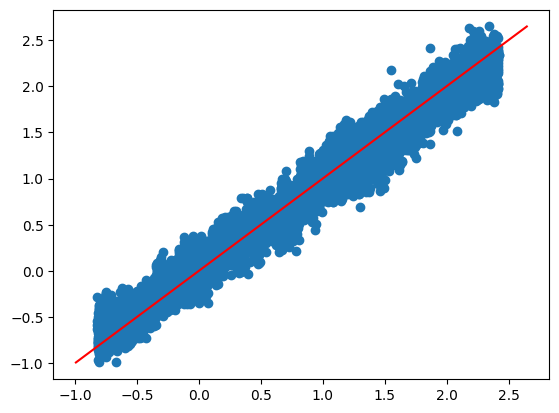

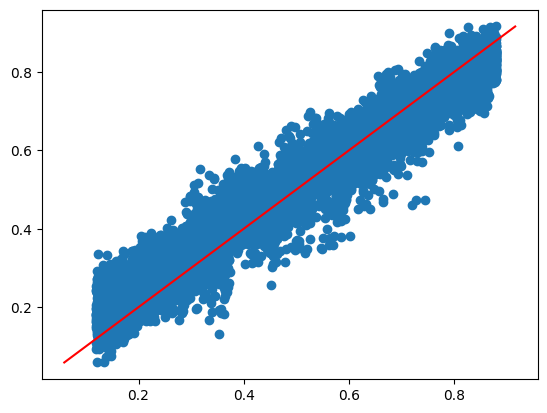

In [9]:
plt.scatter(true_modely(X), y - yres)
plt.plot(np.linspace(np.min(y - yres), np.max(y - yres), 100),
         np.linspace(np.min(y - yres), np.max(y - yres), 100), color='r')
plt.show()
plt.scatter(true_modeld(X), D - Dres)
plt.plot(np.linspace(np.min(D - Dres), np.max(D - Dres), 100),
         np.linspace(np.min(D - Dres), np.max(D - Dres), 100), color='r')
plt.show()

In [10]:
# Double ML method
from joblib import Parallel, delayed

def exp(it, n, d, delta=1.0, base=0.3):
    np.random.seed(it)
    y, D, X, _, _ = gen_data(n, d, delta, base)
    hat, stderr, yres, Dres = doubleml(y, D, X)
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
    return hat, stderr, (ci[0] <= delta) & (delta <= ci[1])

n = 10000
d = 5
res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, d) for it in range(100))
hats, stderrs, cov = zip(*res)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.0s finished


In [11]:
np.mean(cov)

0.91

In [12]:
1 - np.mean(hats), np.std(hats), np.mean(stderrs) # very small bias compared to standard deviation

(0.010381750550889968, 0.02368417233119091, 0.02301517649712954)

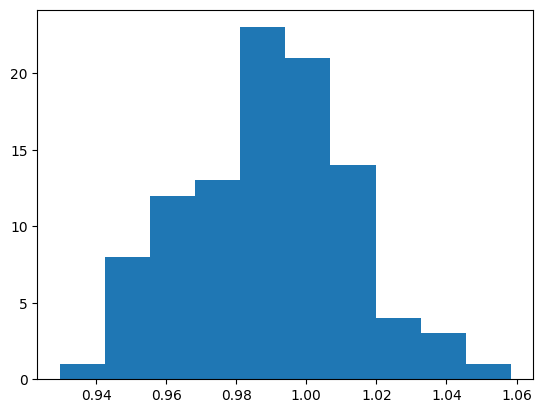

In [13]:
plt.hist(hats)
plt.show()

# Doubly Robust Estimator without any Assumptions

In [14]:
from sklearn.model_selection import KFold

def doublerobust(y, D, X,
                 modely=generic_ml_model(),
                 modeld=generic_ml_model()):
    yhat0, yhat1, Dhat = np.zeros(y.shape), np.zeros(y.shape), np.zeros(D.shape)
    for train, test in KFold(n_splits=5, shuffle=True).split(X, D):
        yhat0[test] = modely.fit(X[train][D[train]==0], y[train][D[train]==0]).predict(X[test])
        yhat1[test] = modely.fit(X[train][D[train]==1], y[train][D[train]==1]).predict(X[test])
        Dhat[test] = modeld.fit(X[train], D[train]).predict(X[test])
    yhat = yhat0 * (D == 0) + yhat1 * (D == 1)
    alpha = D / Dhat - (1 - D) / (1 - Dhat)
    ydr = yhat1 - yhat0 + alpha * (y - yhat)
    point = np.mean(ydr)
    stderr = np.sqrt(np.var(ydr) / y.shape[0])
    return point, stderr, yhat, Dhat

In [15]:
np.random.seed(1234)
n = 10000
d = 5
delta = 1.0
base = 0.3
y, D, X, true_modeld, true_modely = gen_data(n, d, delta, base)
hat, stderr, yhat, Dhat = doublerobust(y, D, X) # we apply the double lasso process
ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
print(f"hat: {hat:.3f}, stderr: {stderr:.3f}, CI: ({ci[0]:.3f}, {ci[1]:.3f}), cov={(ci[0] <= delta) & (delta <= ci[1])}")
# R^2 for outcome and treatment model
print(f"R2(y): {1 - np.mean((y - yhat)**2) / np.var(y):.3f}, R2(D): {1 - np.mean((D - Dhat)**2) / np.var(D):.3f}")

hat: 0.964, stderr: 0.023, CI: (0.919, 1.008), cov=True
R2(y): 0.490, R2(D): 0.212


In [16]:
# Doubly robust method
from joblib import Parallel, delayed

def exp(it, n, d, delta=1.0, base=0.3):
    np.random.seed(it)
    y, D, X, _, _ = gen_data(n, d, delta, base)
    hat, stderr, yhat, Dhat = doublerobust(y, D, X)
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
    return hat, stderr, (ci[0] <= delta) & (delta <= ci[1])

n = 10000
d = 5
res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, d) for it in range(200))
hats, stderrs, cov = zip(*res)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   20.9s finished


In [17]:
np.mean(cov)

0.925

In [18]:
1 - np.mean(hats), np.std(hats), np.mean(stderrs) # very small bias compared to standard deviation

(0.0077342862032425685, 0.024208955205974783, 0.023682118141031515)

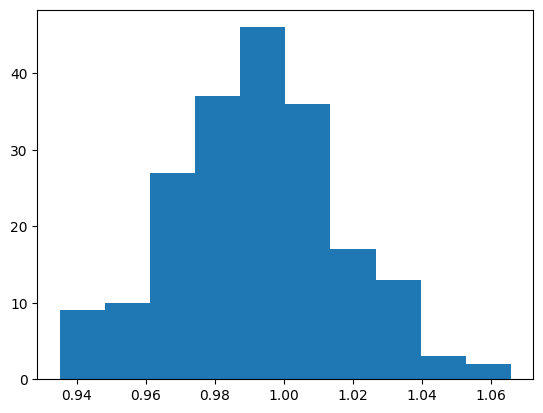

In [19]:
plt.hist(hats)
plt.show()

# Double ML with Auto-ML Estimators and Semi-Crossfitting

In [ ]:
!pip install flaml

In [21]:
from sklearn.model_selection import cross_val_predict
from flaml import AutoML

def automl_model():
    return AutoML(time_budget=10, task='regression', early_stop=True,
                  max_iter=1000, eval_method='holdout', metric='r2',
                  split_ratio=0.2, verbose=0,
                  estimator_list=['rf', 'lgbm', 'xgboost', 'xgb_limitdepth',
                                  'extra_tree', 'enet', 'sgd', 'lassolars'])

def auto_doubleml(y, D, X,
                  modely=automl_model(),
                  modeld=automl_model()):
    modely.fit(X, y)
    print(f"Chosen modely: {modely.best_estimator}")
    modely = modely.best_model_for_estimator(modely.best_estimator)
    print("Parameters: ", modely.params)
    modeld.fit(X, D)
    print(f"Chosen modeld: {modeld.best_estimator}")
    modeld = modeld.best_model_for_estimator(modeld.best_estimator)
    print("Parameters: ", modeld.params)
    yres = y - cross_val_predict(modely, X, y, cv=5)
    Dres = D - cross_val_predict(modeld, X, D, cv=5)
    # rest is the same as in the OLS case
    hat = np.mean(yres * Dres) / np.mean(Dres**2)
    epsilon = yres - hat * Dres
    V = np.mean(epsilon**2 * Dres**2) / np.mean(Dres**2)**2
    return hat, np.sqrt(V / y.shape[0]), yres, Dres

In [22]:
np.random.seed(1234)
n = 10000
d = 10
delta = 1.0
base = 0.3
y, D, X, true_modeld, true_modely = gen_data(n, d, delta, base)
hat, stderr, yres, Dres = auto_doubleml(y, D, X)
ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
print(f"hat: {hat:.3f}, stderr: {stderr:.3f}, CI: ({ci[0]:.3f}, {ci[1]:.3f}), cov={(ci[0] <= delta) & (delta <= ci[1])}")
# R^2 for outcome and treatment model
print(f"R2(y): {1 - np.mean(yres**2) / np.var(y):.3f}, R2(D): {1 - np.mean(Dres**2) / np.var(D):.3f}")

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune
INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune
INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


Chosen modely: lassolars
Parameters:  {'alpha': 0.03930090379341948, 'fit_intercept': True, 'eps': 1e-16}


INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune
INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune
INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


Chosen modeld: extra_tree
Parameters:  {'n_estimators': 4, 'max_features': 1.0, 'n_jobs': -1, 'max_leaf_nodes': 9, 'random_state': 12032022, 'verbose': 0}
hat: 0.951, stderr: 0.023, CI: (0.905, 0.997), cov=False
R2(y): 0.418, R2(D): 0.250


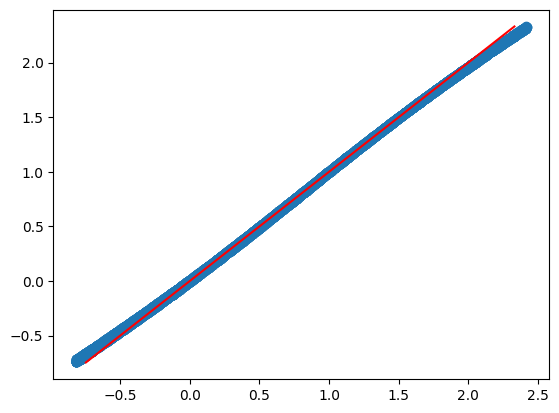

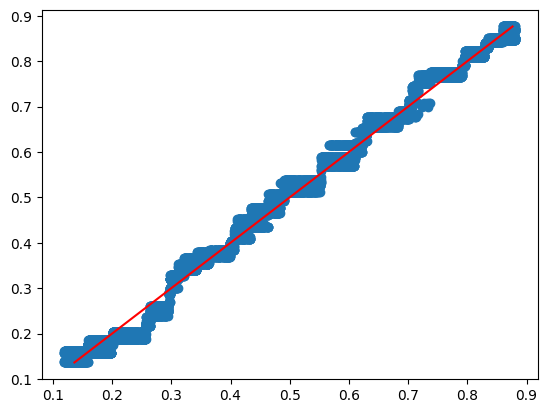

In [23]:
plt.scatter(true_modely(X), y - yres)
plt.plot(np.linspace(np.min(y - yres), np.max(y - yres), 100),
         np.linspace(np.min(y - yres), np.max(y - yres), 100), color='r')
plt.show()
plt.scatter(true_modeld(X), D - Dres)
plt.plot(np.linspace(np.min(D - Dres), np.max(D - Dres), 100),
         np.linspace(np.min(D - Dres), np.max(D - Dres), 100), color='r')
plt.show()

In [24]:
# Double ML method
from joblib import Parallel, delayed

def exp(it, n, d, delta=1.0, base=0.3):
    np.random.seed(it)
    y, D, X, _, _ = gen_data(n, d, delta, base)
    hat, stderr, yres, Dres = auto_doubleml(y, D, X)
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
    return hat, stderr, (ci[0] <= delta) & (delta <= ci[1])

n = 10000
d = 5
res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, d) for it in range(100))
hats, stderrs, cov = zip(*res)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished


In [25]:
np.mean(cov)

0.96

In [26]:
1 - np.mean(hats), np.std(hats), np.mean(stderrs) # very small bias compared to standard deviation

(-0.0002590978843490799, 0.0226547389654036, 0.022903920762728004)

# Automatic Doubly Robust Method: Automatic Estimation of alpha function

In [ ]:
!git clone https://github.com/victor5as/RieszLearning.git
!pip install econml

In [28]:
from RieszLearning.utils.forestriesz import RFrr, poly_feature_fns
from RieszLearning.utils.moments import ate_moment_fn
from sklearn.model_selection import KFold


def generic_riesz_model():
    return RFrr(riesz_feature_fns=poly_feature_fns(1), moment_fn=lambda x, test_fn: ate_moment_fn(x, test_fn, None))

def autodml(y, D, X,
            modely=generic_ml_model(),
            modelriesz=generic_riesz_model()):
    yhat0, yhat1, alpha = np.zeros(y.shape), np.zeros(y.shape), np.zeros(D.shape)
    for train, test in KFold(n_splits=5, shuffle=True).split(X, D):
        yhat0[test] = modely.fit(X[train][D[train]==0], y[train][D[train]==0]).predict(X[test])
        yhat1[test] = modely.fit(X[train][D[train]==1], y[train][D[train]==1]).predict(X[test])
        alpha[test] = modelriesz.fit(X[train], D[train], y[train]).predict_riesz(np.hstack([D[test].reshape(-1, 1), X[test]]))
    yhat = yhat0 * (D == 0) + yhat1 * (D == 1)
    ydr = yhat1 - yhat0 + alpha * (y - yhat)
    point = np.mean(ydr)
    stderr = np.sqrt(np.var(ydr) / y.shape[0])
    return point, stderr, yhat, Dhat

In [29]:
np.random.seed(1234)
n = 10000
d = 5
delta = 1.0
base = 0.3
y, D, X, true_modeld, true_modely = gen_data(n, d, delta, base)
hat, stderr, yhat, Dhat = autodml(y, D, X) # we apply the double lasso process
ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
print(f"hat: {hat:.3f}, stderr: {stderr:.3f}, CI: ({ci[0]:.3f}, {ci[1]:.3f}), cov={(ci[0] <= delta) & (delta <= ci[1])}")
# R^2 for outcome and treatment model
print(f"R2(y): {1 - np.mean((y - yhat)**2) / np.var(y):.3f}, R2(D): {1 - np.mean((D - Dhat)**2) / np.var(D):.3f}")

hat: 0.961, stderr: 0.022, CI: (0.919, 1.004), cov=True
R2(y): 0.492, R2(D): 0.212


In [30]:
# Doubly robust method
from joblib import Parallel, delayed

def exp(it, n, d, delta=1.0, base=0.3):
    np.random.seed(it)
    y, D, X, _, _ = gen_data(n, d, delta, base)
    hat, stderr, yhat, Dhat = autodml(y, D, X)
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
    return hat, stderr, (ci[0] <= delta) & (delta <= ci[1])

n = 10000
d = 5
res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, d) for it in range(200))
hats, stderrs, cov = zip(*res)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.2min finished


In [31]:
np.mean(cov)

0.915

In [32]:
1 - np.mean(hats), np.std(hats), np.mean(stderrs) # very small bias compared to standard deviation

(0.00708533478394946, 0.024362031297142244, 0.0223167931352133)